In [ ]:
#@title 🛠️ Install Required Libraries
!pip install -q segmentation-models-pytorch albumentations rasterio gdown


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 925.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.9 MB/s eta 0:00:00


In [ ]:
#@title 🔗 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda


In [ ]:
#@title 📦 Import All Libraries


from glob import glob
from sklearn.model_selection import train_test_split


import os
import torch
import rasterio
import albumentations as A
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from torchvision import transforms as T
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F
#import torchsummary
from tqdm import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import numpy as np
from sklearn.metrics import f1_score


In [ ]:
# @title 📁 Set Dataset Paths and Match 400 Random Image-Mask Pairs
import os
import glob
import random

def get_all_tif_files(folder):
    return sorted(glob.glob(os.path.join(folder, "*.tif"))) + \
           sorted(glob.glob(os.path.join(folder, "*.TIF")))

mask_dir = "/content/drive/MyDrive/Khushi_drive/All_Masks_TIF"
image_dir = "/content/drive/MyDrive/Khushi_drive/GEE_Exports_all"

mask_paths = get_all_tif_files(mask_dir)
image_paths = get_all_tif_files(image_dir)

print(f"✅ Found {len(mask_paths)} masks and {len(image_paths)} images.")

image_mask_pairs = []

for mask_path in mask_paths:
    mask_filename = os.path.basename(mask_path)  # e.g., "1_id_200.tif"
    core_id = "_".join(mask_filename.split("_")[1:])  # id_200.tif
    image_path = os.path.join(image_dir, core_id)
    if os.path.exists(image_path):
        image_mask_pairs.append((image_path, mask_path))

# Shuffle and select random 400
random.shuffle(image_mask_pairs)
image_mask_pairs = image_mask_pairs[:400]

# Split into separate lists
image_paths = [pair[0] for pair in image_mask_pairs]
mask_paths = [pair[1] for pair in image_mask_pairs]

print(f"Image directory: {image_dir}")
print(f"Mask directory: {mask_dir}")
print(f"Found {len(image_mask_pairs)} image-mask pairs (random 400)")


✅ Found 0 masks and 0 images.
Image directory: /content/drive/MyDrive/Khushi_drive/GEE_Exports_all
Mask directory: /content/drive/MyDrive/Khushi_drive/All_Masks_TIF
Found 0 image-mask pairs (random 400)


In [ ]:
zero_masks = [p for p in mask_paths if os.path.basename(p).startswith("0_")]
one_masks = [p for p in mask_paths if os.path.basename(p).startswith("1_")]

print(f"🛩️ Airstrip present (1_): {len(one_masks)}")
print(f"🚫 No airstrip (0_): {len(zero_masks)}")


🛩️ Airstrip present (1_): 0
🚫 No airstrip (0_): 0


In [ ]:
#@title 🧾 Custom Dataset

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='rasterio')

#@title 🛠️ FIXED Dataset Class - This is likely your main issue

class AirstripSentinelDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

        # Validate that we have actual positive samples
        self._check_masks()

    def _check_masks(self):
        """Check if masks contain positive samples"""
        positive_count = 0
        for mask_path in self.mask_paths[:10]:  # Check first 10
            try:
                with rasterio.open(mask_path) as msk:
                    mask = msk.read(1)
                    if mask.max() > 0:
                        positive_count += 1
                        print(f"✅ Found positive mask: {os.path.basename(mask_path)} - {mask.sum()} positive pixels")
                    else:
                        print(f"❌ Empty mask: {os.path.basename(mask_path)}")
            except Exception as e:
                print(f"Error reading {mask_path}: {e}")

        print(f"Positive masks found: {positive_count}/10")
        if positive_count == 0:
            print("⚠️  WARNING: No positive samples found! Check your mask files.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        try:
            # Load image
            with rasterio.open(img_path) as src:
                img = src.read([3, 4, 8])  # RGB-like Sentinel bands
                img = np.transpose(img, (1, 2, 0)).astype(np.float32)

                # Handle different possible value ranges
                if img.max() > 100:  # Likely 0-10000 range
                    img = np.clip(img / 10000.0, 0, 1)
                elif img.max() > 10:  # Likely 0-255 range
                    img = np.clip(img / 255.0, 0, 1)
                # else: already 0-1 range

                # Replace any NaN/inf values
                img = np.nan_to_num(img, nan=0.0, posinf=1.0, neginf=0.0)

            # Load mask
            with rasterio.open(mask_path) as msk:
                mask = msk.read(1).astype(np.float32)

                # Ensure binary mask
                mask = (mask > 0).astype(np.float32)

                # Replace any NaN/inf values
                mask = np.nan_to_num(mask, nan=0.0, posinf=1.0, neginf=0.0)

            # Apply transforms
            if self.transform:
                augmented = self.transform(image=img, mask=mask)
                img = augmented["image"]
                mask = augmented["mask"]

            return img, mask.unsqueeze(0)

        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            # Return a dummy sample to avoid breaking training
            dummy_img = torch.zeros(3, 512, 512)
            dummy_mask = torch.zeros(1, 512, 512)
            return dummy_img, dummy_mask

In [ ]:
#@title 🎨 Define Transforms

# def get_transforms(train=True):
#     if train:
#         return A.Compose([
#             A.Resize(512, 512),
#             A.HorizontalFlip(p=0.5),
#             A.RandomBrightnessContrast(p=0.3),
#             A.Normalize(),
#             ToTensorV2()
#         ])
#     else:
#         return A.Compose([
#             A.Resize(512, 512),
#             A.Normalize(),
#             ToTensorV2()
#         ])


#@title 🎨 Fixed Transforms
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(512, 512),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
            # Remove A.Normalize() since we handle it in dataset
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(512, 512),
            ToTensorV2()
        ])

In [ ]:
def get_augmentations(option='train'):
    # Mean and std for RGB bands (B4, B3, B2)
    mean = (0.485, 0.456, 0.406)  # B4, B3, B2
    std = (0.229, 0.224, 0.225)

    # Define augmentation pipeline based on phase
    augmentations = {
        'train': [
            A.CropNonEmptyMaskIfExists(width=224, height=224),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
        ],
        'val': [
            A.CropNonEmptyMaskIfExists(width=224, height=224),
        ],
        'test': [
            A.CropNonEmptyMaskIfExists(width=224, height=224),
        ],
        'inference': [
            A.CenterCrop(width=224, height=224),
        ]
    }

    if option not in augmentations:
        raise ValueError("Invalid option. Choose from 'train', 'val', 'test', or 'inference'.")

    # Add normalization and tensor transformation
    augmentations[option].extend([
        A.Normalize(mean=mean, std=std, max_pixel_value=1.0),
        ToTensorV2(),
    ])

    return A.Compose(augmentations[option], additional_targets={'mask': 'mask'})


In [ ]:
#@title 🧠 Load Model and Define Loss

# def get_model(name="deeplabv3"):
#     if name == "deeplabv3":
#         model = smp.DeepLabV3(
#             encoder_name="resnet50",
#             encoder_weights="imagenet",
#             in_channels=3,
#             classes=1,
#         )
#     else:
#         raise NotImplementedError("Only DeepLabV3 is implemented.")
#     return model.cuda()

# loss_fn = smp.losses.FocalLoss(mode='binary')

# UNet model with ResNet50 encoder
def get_model(in_channels=3):
    model = smp.Unet(
        encoder_name='resnet50',        # Choose encoder, ResNet50 in this case
        encoder_weights='imagenet',     # Use pre-trained weights
        in_channels=in_channels,                  # RGB, modify later for more channels
        classes=1,                      # Binary segmentation
    )
    return model

In [ ]:
!pip install tqdm

In [ ]:
# #@title 🚂 Train and Validate

# # def train(model, train_loader, val_loader, epochs=25):
# #     optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# #     for epoch in range(epochs):
# #         model.train()
# #         total_loss = 0
# #         for img, mask in train_loader:
# #             img, mask = img.cuda(), mask.cuda()
# #             pred = model(img)
# #             loss = loss_fn(pred, mask)
# #             optimizer.zero_grad()
# #             loss.backward()
# #             optimizer.step()
# #             total_loss += loss.item()
# #         print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.4f}")

# #         model.eval()
# #         with torch.no_grad():
# #             scores = []
# #             for img, mask in val_loader:
# #                 img, mask = img.cuda(), mask.cuda()
# #                 pred = torch.sigmoid(model(img)) > 0.5
# #                 f1 = f1_score(mask.view(-1).cpu(), pred.view(-1).cpu())
# #                 scores.append(f1)
# #             print(f"Validation F1: {np.mean(scores):.4f}")

# #@title 🚂 Enhanced Training Function with Progress Tracking

# from tqdm import tqdm

# def train_with_history(model, train_loader, val_loader, epochs=25):
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

#     # Initialize history
#     history = {
#         'train_loss': [], 'val_loss': [],
#         'train_iou': [], 'val_iou': [],
#         'train_f1': [], 'val_f1': [],
#         'learning_rates': []
#     }

#     def calculate_iou(pred, target):
#         pred = (torch.sigmoid(pred) > 0.5).float()
#         intersection = (pred * target).sum()
#         union = pred.sum() + target.sum() - intersection
#         return (intersection / (union + 1e-8)).item()

#     best_val_iou = 0.0

#     for epoch in range(epochs):
#         print(f"\n{'='*60}")
#         print(f"Epoch {epoch+1}/{epochs} - Progress: {(epoch+1)/epochs*100:.1f}%")
#         print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
#         print(f"{'='*60}")

#         # Training
#         model.train()
#         train_loss, train_iou, train_f1 = 0, 0, 0

#         train_pbar = tqdm(train_loader, desc=f"Training")
#         for batch_idx, (img, mask) in enumerate(train_pbar):
#             img, mask = img.cuda(), mask.cuda()

#             optimizer.zero_grad()
#             pred = model(img)
#             loss = loss_fn(pred, mask)

#             # Check for NaN
#             if torch.isnan(loss):
#                 print(f"NaN detected at batch {batch_idx}, skipping...")
#                 continue

#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             optimizer.step()

#             # Calculate metrics
#             with torch.no_grad():
#                 batch_iou = calculate_iou(pred, mask)
#                 pred_binary = (torch.sigmoid(pred) > 0.5).float()
#                 batch_f1 = f1_score(
#                     mask.view(-1).cpu().numpy(),
#                     pred_binary.view(-1).cpu().numpy(),
#                     zero_division=0
#                 )

#             train_loss += loss.item()
#             train_iou += batch_iou
#             train_f1 += batch_f1

#             train_pbar.set_postfix({
#                 'Loss': f'{loss.item():.4f}',
#                 'IoU': f'{batch_iou:.4f}'
#             })

#         # Average training metrics
#         train_loss /= len(train_loader)
#         train_iou /= len(train_loader)
#         train_f1 /= len(train_loader)

#         # Validation
#         model.eval()
#         val_loss, val_iou, val_f1 = 0, 0, 0

#         val_pbar = tqdm(val_loader, desc=f"Validation")
#         with torch.no_grad():
#             for img, mask in val_pbar:
#                 img, mask = img.cuda(), mask.cuda()
#                 pred = model(img)
#                 loss = loss_fn(pred, mask)

#                 batch_iou = calculate_iou(pred, mask)
#                 pred_binary = (torch.sigmoid(pred) > 0.5).float()
#                 batch_f1 = f1_score(
#                     mask.view(-1).cpu().numpy(),
#                     pred_binary.view(-1).cpu().numpy(),
#                     zero_division=0
#                 )

#                 val_loss += loss.item()
#                 val_iou += batch_iou
#                 val_f1 += batch_f1

#                 val_pbar.set_postfix({
#                     'Loss': f'{loss.item():.4f}',
#                     'IoU': f'{batch_iou:.4f}'
#                 })

#         # Average validation metrics
#         val_loss /= len(val_loader)
#         val_iou /= len(val_loader)
#         val_f1 /= len(val_loader)

#         # Update scheduler
#         scheduler.step(val_loss)

#         # Store in history
#         history['train_loss'].append(train_loss)
#         history['val_loss'].append(val_loss)
#         history['train_iou'].append(train_iou)
#         history['val_iou'].append(val_iou)
#         history['train_f1'].append(train_f1)
#         history['val_f1'].append(val_f1)
#         history['learning_rates'].append(optimizer.param_groups[0]['lr'])

#         # Print epoch summary
#         print(f"\n📊 EPOCH {epoch+1} RESULTS:")
#         print(f"Train - Loss: {train_loss:.4f} | IoU: {train_iou:.4f} | F1: {train_f1:.4f}")
#         print(f"Val   - Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | F1: {val_f1:.4f}")

#         # Save best model
#         if val_iou > best_val_iou:
#             best_val_iou = val_iou
#             torch.save({
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'epoch': epoch,
#                 'best_val_iou': best_val_iou,
#                 'history': history
#             }, '/content/drive/MyDrive/My models/best_airstrip_model.pth')
#             print(f"🎉 NEW BEST MODEL SAVED! IoU: {best_val_iou:.4f}")

#     return history

# Training loop
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()

    total_loss = 0.0
    running_loss = 0.0
    running_total_pixels = 0.0
    running_correct_pixels = 0.0

    for batch_idx, (images, masks) in enumerate(tqdm(dataloader)):
        images = images.to(device)
        # Change data type of masks to float32 before moving to device
        masks = masks.type(torch.float32).to(device).unsqueeze(1)  # Add channel dimension to masks
        images = images.float()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        ## Next line is an attempt at limiting loss from exploding.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients to a maximum norm of 1
        optimizer.step()

        # Calculate per-pixel accuracy
        preds = torch.sigmoid(outputs) > 0.5  # Threshold to convert logits to binary predictions (for binary segmentation)
        correct_pixels = torch.sum(preds == masks).item()
        total_pixels = masks.numel()  # Total number of pixels in the batch

        # Calculate running loss and accuracy
        running_loss += loss.item() * images.size(0)
        running_correct_pixels += correct_pixels
        running_total_pixels += total_pixels

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_correct_pixels / running_total_pixels) * 100  # Pixel-wise accuracy
    print(f"Train Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

    return epoch_loss, epoch_accuracy

In [ ]:
def evaluate(model, dataloader, criterion, device, phase="val", plot=False):
    model.eval()

    running_loss = 0
    running_correct_pixels = 0
    total_iou = 0
    num_samples = 0
    running_total_pixels = 0
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0

    imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]


    for i, (images, masks) in enumerate(tqdm(dataloader)):
        images = images.to(device)
        masks = masks.to(device)

        # Add channel dimension to the target masks
        masks = masks.type(torch.float32)
        masks = masks.unsqueeze(1)


        with torch.set_grad_enabled(False):
            outputs = model(images)
            loss = criterion(outputs, masks)
            # Apply sigmoid to the outputs (for binary segmentation) and threshold
            preds = torch.sigmoid(outputs) > 0.5

        # Calculate per-pixel accuracy
        correct_pixels = torch.sum(preds == masks).item()
        total_pixels = masks.numel()
        running_correct_pixels += correct_pixels
        running_total_pixels += total_pixels

         # Calculate IoU and F1 score metrics
        for j in range(images.shape[0]):
            prediction = preds[j].squeeze(0)  # Remove channel dimension
            #prediction = (prediction > 0.5).float()  # Example threshold of 0.5
            iou = calculate_jaccard_index(prediction, masks[j])
            total_iou += iou

            # Calculate TP, FP, FN for F1 score
            true_positive = torch.sum((prediction == 1) & (masks[j] == 1)).item()
            false_positive = torch.sum((prediction == 1) & (masks[j] == 0)).item()
            false_negative = torch.sum((prediction == 0) & (masks[j] == 1)).item()

            total_true_positives += true_positive
            total_false_positives += false_positive
            total_false_negatives += false_negative
            num_samples += 1


        if plot:
            # Plot image, mask, and prediction for a sample in the batch
            for i in range(images.shape[0]):  # Loop through batch
                image = images[i, :3, :, :].cpu().permute(1, 2, 0).numpy()  # Move to CPU, permute for plotting
                image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)
                mask = masks[i].cpu().squeeze().numpy()
                prediction = outputs[i].cpu().squeeze()

                # Apply sigmoid for binary segmentation if your model output is logits.
                prediction = torch.sigmoid(prediction)

                # Threshold predictions (adjust threshold as needed)
                prediction = (prediction > 0.5).float().numpy()  # Example threshold of 0.5

                plot_predictions(image, mask, prediction) # Call plot function

        running_loss += loss.item() * images.size(0)

    # Calculate metrics
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_correct_pixels / running_total_pixels) * 100  # Pixel-wise accuracy
    average_iou = total_iou / num_samples

    # Calculate Precision, Recall, and F1 score
    precision = total_true_positives / (total_true_positives + total_false_positives + 1e-8)
    recall = total_true_positives / (total_true_positives + total_false_negatives + 1e-8)
    f1_score_value = 2 * (precision * recall) / (precision + recall + 1e-8)


    print(f"{phase.title()} Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")
    print(f"Average Jaccard Index (IoU): {average_iou:.4f}")

    return epoch_loss, epoch_accuracy, average_iou, f1_score_value  # Return the average validation loss

In [ ]:
def fit(model, train_loader, val_loader, n_epochs, criterion, optimizer, device):
    # Keep track of the best loss and
    # best model weights with the lowest loss

    best_loss = np.inf # Initialize with a very high value
    best_model = model.state_dict() # Initialize with the initial model state

    train_losses = []
    train_accuracy = []
    val_losses = []
    val_accuracy = []
    val_jaccard = []
    val_f1_scores = []  # Track validation F1 scores


    # Train and test over n_epochs
    for epoch in range(n_epochs):
        print("Epoch {}".format(epoch+1))
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)

        val_loss, val_acc, val_jac, val_f1 = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracy.append(val_acc)
        val_jaccard.append(val_jac)
        val_f1_scores.append(val_f1)

        # #### NEW CODE
        # # Step the scheduler with validation loss
        # scheduler.step(val_loss)
        # ### END

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()

    # Load the best model state
    model.load_state_dict(best_model)

    # Plotting the loss curves
    # Plotting the training curves
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))  # 3 subplots for Loss, Accuracy, Jaccard

    # Loss subplot
    axes[0].plot(train_losses, label='Training Loss')
    axes[0].plot(val_losses, label='Validation Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy subplot
    axes[1].plot(train_accuracy, label='Training Accuracy')
    axes[1].plot(val_accuracy, label='Validation Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Jaccard subplot
    axes[2].plot(val_jaccard, label='Validation Jaccard')
    axes[2].set_title('Jaccard Index')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Jaccard Index')
    axes[2].legend()

    axes[3].plot(val_f1_scores, label='Validation F1 Score')
    axes[3].set_title('F1 Score')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('F1 Score')
    axes[3].legend()

    plt.tight_layout()
    plt.show()


    return model

In [ ]:
def plot_predictions(image, mask, prediction):
    """Plots the image, mask, and prediction side-by-side."""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(mask, cmap='gray')
    ax2.set_title("Mask")
    ax3.imshow(prediction, cmap='gray')
    ax3.set_title("Prediction")
    plt.show()


In [ ]:
def calculate_jaccard_index(y_pred, y_true, smooth=1e-6):
    """Calculates the Jaccard index (IoU) between predictions and targets."""

    # Check if inputs are NumPy arrays and convert if necessary
    if isinstance(y_pred, np.ndarray):
        y_pred = torch.from_numpy(y_pred)
    if isinstance(y_true, np.ndarray):  # Check if y_true is a NumPy array before converting
        y_true = torch.from_numpy(y_true)

    # Flatten predictions and targets using torch.flatten
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()

    # Calculate intersection and union
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)

    # Check if iou is a single-element tensor before calling .item()
    if iou.dim() == 0:
        return iou.item()  # Return as a single number
    else:
        return iou  # Return the tensor as is if it has multiple elements

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt is the probability of the correct class
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return torch.mean(F_loss)

CHECK GPU

In [ ]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


In [ ]:
image_dir = '/content/drive/MyDrive/P2 - Amazon ITU - PESU/GEE_Exports_all'
mask_dir = '/content/drive/MyDrive/P2 - Amazon ITU - PESU/All_Masks_TIF'

# List image and mask file paths
image_paths = [os.path.join(image_dir, img) for img in sorted(os.listdir(image_dir)) if img.endswith('.tif')]
mask_paths = [os.path.join(mask_dir, mask) for mask in sorted(os.listdir(mask_dir)) if mask.endswith('.tif')]

In [ ]:


# Create datasets using AirstripSentinelDataset (no additional_bands needed)
train_data = AirstripSentinelDataset(
    image_paths=image_paths,
    mask_paths=mask_paths,
    transform=get_augmentations(option='train')  # Removed optional_bands param
)

val_data = AirstripSentinelDataset(
    image_paths=image_paths,
    mask_paths=mask_paths,
    transform=get_augmentations(option='val')  # Removed optional_bands param
)

test_data = AirstripSentinelDataset(
    image_paths=image_paths,
    mask_paths=mask_paths,
    transform=get_augmentations(option='test')  # Removed optional_bands param
)

# Split into 80% train / 10% val / 10% test
train_size = 0.80
val_size = 0.10
indices = list(range(len(train_data)))
train_split = int(train_size * len(train_data))
val_split = int(val_size * len(train_data))  # should be based on train_data for same total size
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:train_split])
val_data = data.Subset(val_data, indices=indices[train_split: train_split + val_split])
test_data = data.Subset(test_data, indices=indices[train_split + val_split:])

print("Train/val/test sizes: {}/{}/{}".format(len(train_data), len(val_data), len(test_data)))


❌ Empty mask: 0_id_1017.tif
❌ Empty mask: 0_id_1030.tif
❌ Empty mask: 0_id_1035.tif
❌ Empty mask: 0_id_1036.tif
❌ Empty mask: 0_id_1040.tif
❌ Empty mask: 0_id_1042.tif
❌ Empty mask: 0_id_1047.tif
❌ Empty mask: 0_id_1051.tif
❌ Empty mask: 0_id_1052.tif
❌ Empty mask: 0_id_1056.tif
Positive masks found: 0/10
⚠️  WARNING: No positive samples found! Check your mask files.
❌ Empty mask: 0_id_1017.tif
❌ Empty mask: 0_id_1030.tif
❌ Empty mask: 0_id_1035.tif
❌ Empty mask: 0_id_1036.tif
❌ Empty mask: 0_id_1040.tif
❌ Empty mask: 0_id_1042.tif
❌ Empty mask: 0_id_1047.tif
❌ Empty mask: 0_id_1051.tif
❌ Empty mask: 0_id_1052.tif
❌ Empty mask: 0_id_1056.tif
Positive masks found: 0/10
⚠️  WARNING: No positive samples found! Check your mask files.
❌ Empty mask: 0_id_1017.tif
❌ Empty mask: 0_id_1030.tif
❌ Empty mask: 0_id_1035.tif
❌ Empty mask: 0_id_1036.tif
❌ Empty mask: 0_id_1040.tif
❌ Empty mask: 0_id_1042.tif
❌ Empty mask: 0_id_1047.tif
❌ Empty mask: 0_id_1051.tif
❌ Empty mask: 0_id_1052.tif
❌ Empty 

In [ ]:
batch_size = 8
num_workers = 2

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [ ]:
try:
    del model  # Try to delete the model
except NameError:
    pass  # If the model isn't defined, do nothing

In [ ]:
model = get_model(in_channels=5).to(device)
#torchsummary.summary(model, (5, 224, 224))
#print(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
# !pip -q install torchinfo
# from torchinfo import summary

# summary(model, input_size=(8, 5, 224, 224))  # batch size 1

In [ ]:
#criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([500], dtype=torch.float32).to(device))  # Binary cross-entropy loss
criterion = FocalLoss(alpha=1, gamma=2)
#criterion = DiceLoss()
#criterion = BCEDiceLoss()
#criterion = JaccardLoss()


# Separate parameters based on whether they were pre-trained or initialized
pretrained_params = [param for name, param in model.named_parameters() if 'encoder' in name]
new_params = [param for name, param in model.named_parameters() if 'encoder' not in name]

# Define a lower learning rate for new layers
optimizer = torch.optim.Adam([
    {'params': pretrained_params, 'lr': 5e-4},
    {'params': new_params, 'lr': 5e-4}  # Lower learning rate for new params
], weight_decay=0)

#### NEW CODE
# # Add scheduler here
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
# ### END

#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 100


In [ ]:
best_model = fit(model, train_loader, val_loader, epochs, criterion=criterion, optimizer=optimizer, device=device)

# Training loop
#for epoch in range(epochs):
#    print(f"Epoch {epoch+1}/{epochs}")
#    train_model(model, train_loader, criterion, optimizer, device)


#for epoch in range(epochs):
#    print(f"Epoch {epoch+1}/{epochs}")
#    train_model(model, train_loader, criterion, optimizer, device)


Epoch 1


  0%|          | 0/127 [00:00<?, ?it/s]


IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataset.py", line 420, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataset.py", line 420, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-4095057891.py", line 41, in __getitem__
    mask_path = self.mask_paths[idx]
                ~~~~~~~~~~~~~~~^^^^^
IndexError: list index out of range


In [ ]:
#@title ▶️ Run Training

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

train_ds = AirstripSentinelDataset(train_imgs, train_masks, transform=get_transforms(train=True))
val_ds = AirstripSentinelDataset(val_imgs, val_masks, transform=get_transforms(train=False))

# train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
# val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

# print("Training on:")
# print([os.path.basename(p) for p in train_imgs[:5]], "...")

# model = get_model("deeplabv3")
# train(model, train_loader, val_loader, epochs=25)

#@title ▶️ Run Improved Training

# Reduce batch size to avoid memory issues and improve stability
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2)

print("Training on:")
print([os.path.basename(p) for p in train_imgs[:5]], "...")

model = get_model("deeplabv3").to(device)
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

# Start training with history tracking
history = train_with_history(model, train_loader, val_loader, epochs=25)

Training on:
['id_1267.tif', 'id_1163.tif', 'id_1620.tif', 'id_801.tif', 'id_1468.tif'] ...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model has 39,633,729 parameters

Epoch 1/25 - Progress: 4.0%
Learning Rate: 1.00e-04


Training:   1%|▏         | 1/80 [00:09<12:03,  9.16s/it]

NaN detected at batch 0, skipping...


Training:   2%|▎         | 2/80 [00:09<05:18,  4.08s/it]

NaN detected at batch 1, skipping...


Training:   4%|▍         | 3/80 [00:11<04:11,  3.26s/it]

NaN detected at batch 2, skipping...


Training:   8%|▊         | 6/80 [00:18<02:37,  2.12s/it, Loss=0.1318, IoU=0.0033]

NaN detected at batch 5, skipping...


Training:   9%|▉         | 7/80 [00:19<02:18,  1.89s/it, Loss=0.1318, IoU=0.0033]

NaN detected at batch 6, skipping...


Training:  10%|█         | 8/80 [00:20<01:54,  1.60s/it, Loss=0.1318, IoU=0.0033]

NaN detected at batch 7, skipping...


Training:  12%|█▎        | 10/80 [00:22<01:26,  1.24s/it, Loss=0.1199, IoU=0.0031]

NaN detected at batch 9, skipping...


Training:  14%|█▍        | 11/80 [00:24<01:31,  1.32s/it, Loss=0.1199, IoU=0.0031]

NaN detected at batch 10, skipping...


Training:  15%|█▌        | 12/80 [00:25<01:41,  1.49s/it, Loss=0.1199, IoU=0.0031]

NaN detected at batch 11, skipping...


Training:  19%|█▉        | 15/80 [00:33<01:55,  1.78s/it, Loss=0.1107, IoU=0.0004]

NaN detected at batch 14, skipping...


Training:  20%|██        | 16/80 [00:33<01:27,  1.37s/it, Loss=0.1107, IoU=0.0004]

NaN detected at batch 15, skipping...


Training:  21%|██▏       | 17/80 [00:35<01:20,  1.27s/it, Loss=0.1107, IoU=0.0004]

NaN detected at batch 16, skipping...


Training:  25%|██▌       | 20/80 [00:39<01:20,  1.34s/it, Loss=0.1073, IoU=0.0005]

NaN detected at batch 19, skipping...


Training:  26%|██▋       | 21/80 [00:41<01:24,  1.44s/it, Loss=0.1073, IoU=0.0005]

NaN detected at batch 20, skipping...


Training:  28%|██▊       | 22/80 [00:41<01:05,  1.13s/it, Loss=0.1073, IoU=0.0005]

NaN detected at batch 21, skipping...


Training:  30%|███       | 24/80 [00:45<01:21,  1.46s/it, Loss=0.1030, IoU=0.0000]

NaN detected at batch 23, skipping...


Training:  32%|███▎      | 26/80 [00:47<01:03,  1.18s/it, Loss=0.0994, IoU=0.0000]

NaN detected at batch 25, skipping...


Training:  34%|███▍      | 27/80 [00:49<01:15,  1.42s/it, Loss=0.0994, IoU=0.0000]

NaN detected at batch 26, skipping...


Training:  38%|███▊      | 30/80 [00:53<01:03,  1.27s/it, Loss=0.0959, IoU=0.0016]

NaN detected at batch 29, skipping...


Training:  39%|███▉      | 31/80 [00:56<01:28,  1.80s/it, Loss=0.0959, IoU=0.0016]

NaN detected at batch 30, skipping...


Training:  41%|████▏     | 33/80 [00:59<01:11,  1.53s/it, Loss=0.0920, IoU=0.0011]

NaN detected at batch 32, skipping...


Training:  42%|████▎     | 34/80 [00:59<00:55,  1.20s/it, Loss=0.0920, IoU=0.0011]

NaN detected at batch 33, skipping...


Training:  48%|████▊     | 38/80 [01:06<00:53,  1.27s/it, Loss=0.0805, IoU=0.0000]

NaN detected at batch 37, skipping...


Training:  50%|█████     | 40/80 [01:10<00:58,  1.45s/it, Loss=0.0751, IoU=0.0002]

NaN detected at batch 39, skipping...


Training:  51%|█████▏    | 41/80 [01:11<00:57,  1.47s/it, Loss=0.0751, IoU=0.0002]

NaN detected at batch 40, skipping...


Training:  54%|█████▍    | 43/80 [01:15<01:06,  1.79s/it, Loss=0.0701, IoU=0.0000]

NaN detected at batch 42, skipping...


Training:  55%|█████▌    | 44/80 [01:16<00:49,  1.38s/it, Loss=0.0701, IoU=0.0000]

NaN detected at batch 43, skipping...


Training:  57%|█████▊    | 46/80 [01:20<00:53,  1.58s/it, Loss=0.0646, IoU=0.0000]

NaN detected at batch 45, skipping...


Training:  59%|█████▉    | 47/80 [01:21<00:53,  1.61s/it, Loss=0.0646, IoU=0.0000]

NaN detected at batch 46, skipping...


Training:  61%|██████▏   | 49/80 [01:24<00:43,  1.41s/it, Loss=0.0564, IoU=0.0000]

NaN detected at batch 48, skipping...


Training:  62%|██████▎   | 50/80 [01:24<00:33,  1.11s/it, Loss=0.0564, IoU=0.0000]

NaN detected at batch 49, skipping...


Training:  64%|██████▍   | 51/80 [01:27<00:45,  1.56s/it, Loss=0.0564, IoU=0.0000]

NaN detected at batch 50, skipping...


Training:  65%|██████▌   | 52/80 [01:27<00:34,  1.22s/it, Loss=0.0564, IoU=0.0000]

NaN detected at batch 51, skipping...


Training:  70%|███████   | 56/80 [01:33<00:31,  1.31s/it, Loss=0.0424, IoU=0.0000]

NaN detected at batch 55, skipping...


Training:  71%|███████▏  | 57/80 [01:38<00:51,  2.24s/it, Loss=0.0424, IoU=0.0000]

NaN detected at batch 56, skipping...


Training:  72%|███████▎  | 58/80 [01:38<00:37,  1.70s/it, Loss=0.0424, IoU=0.0000]

NaN detected at batch 57, skipping...


Training:  74%|███████▍  | 59/80 [01:40<00:33,  1.60s/it, Loss=0.0424, IoU=0.0000]

NaN detected at batch 58, skipping...


Training:  75%|███████▌  | 60/80 [01:40<00:24,  1.25s/it, Loss=0.0424, IoU=0.0000]

NaN detected at batch 59, skipping...


Training:  78%|███████▊  | 62/80 [01:44<00:27,  1.51s/it, Loss=0.0372, IoU=0.0000]

NaN detected at batch 61, skipping...


Training:  79%|███████▉  | 63/80 [01:46<00:25,  1.48s/it, Loss=0.0372, IoU=0.0000]

NaN detected at batch 62, skipping...


Training:  81%|████████▏ | 65/80 [01:48<00:20,  1.40s/it, Loss=0.0342, IoU=0.0000]

NaN detected at batch 64, skipping...


Training:  82%|████████▎ | 66/80 [01:49<00:15,  1.11s/it, Loss=0.0342, IoU=0.0000]

NaN detected at batch 65, skipping...


Training:  84%|████████▍ | 67/80 [01:51<00:20,  1.57s/it, Loss=0.0342, IoU=0.0000]

NaN detected at batch 66, skipping...


Training:  89%|████████▉ | 71/80 [01:58<00:13,  1.49s/it, Loss=0.0253, IoU=0.0000]

NaN detected at batch 70, skipping...


Training:  91%|█████████▏| 73/80 [02:01<00:10,  1.51s/it, Loss=0.0228, IoU=0.0000]

NaN detected at batch 72, skipping...


Training:  92%|█████████▎| 74/80 [02:02<00:07,  1.19s/it, Loss=0.0228, IoU=0.0000]

NaN detected at batch 73, skipping...


Training:  95%|█████████▌| 76/80 [02:08<00:07,  1.96s/it, Loss=0.0213, IoU=0.0000]

NaN detected at batch 75, skipping...


Training:  96%|█████████▋| 77/80 [02:09<00:05,  1.78s/it, Loss=0.0213, IoU=0.0000]

NaN detected at batch 76, skipping...


Training:  98%|█████████▊| 78/80 [02:10<00:02,  1.39s/it, Loss=0.0213, IoU=0.0000]

NaN detected at batch 77, skipping...


Training: 100%|██████████| 80/80 [02:13<00:00,  1.67s/it, Loss=0.0199, IoU=0.0000]


NaN detected at batch 79, skipping...


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it, Loss=nan, IoU=0.0000]



📊 EPOCH 1 RESULTS:
Train - Loss: 0.0274 | IoU: 0.0002 | F1: 0.0004
Val   - Loss: nan | IoU: 0.0000 | F1: 0.0000

Epoch 2/25 - Progress: 8.0%
Learning Rate: 1.00e-04


Training:   2%|▎         | 2/80 [00:04<02:21,  1.81s/it, Loss=0.0185, IoU=0.0000]

NaN detected at batch 1, skipping...


Training:   4%|▍         | 3/80 [00:04<01:38,  1.28s/it, Loss=0.0185, IoU=0.0000]

NaN detected at batch 2, skipping...


Training:   5%|▌         | 4/80 [00:05<01:12,  1.05it/s, Loss=0.0185, IoU=0.0000]

NaN detected at batch 3, skipping...


Training:   8%|▊         | 6/80 [00:08<01:26,  1.17s/it, Loss=0.0172, IoU=0.0000]

NaN detected at batch 5, skipping...


Training:  10%|█         | 8/80 [00:10<01:16,  1.06s/it, Loss=0.0173, IoU=0.0000]

NaN detected at batch 7, skipping...


Training:  16%|█▋        | 13/80 [00:17<01:18,  1.17s/it, Loss=0.0131, IoU=0.0000]

NaN detected at batch 12, skipping...


Training:  19%|█▉        | 15/80 [00:19<01:08,  1.06s/it, Loss=0.0116, IoU=0.0000]

NaN detected at batch 14, skipping...


Training:  20%|██        | 16/80 [00:20<00:56,  1.14it/s, Loss=0.0116, IoU=0.0000]

NaN detected at batch 15, skipping...


Training:  22%|██▎       | 18/80 [00:23<01:08,  1.11s/it, Loss=0.0108, IoU=0.0000]

NaN detected at batch 17, skipping...


Training:  24%|██▍       | 19/80 [00:23<00:58,  1.04it/s, Loss=0.0108, IoU=0.0000]

NaN detected at batch 18, skipping...


Training:  25%|██▌       | 20/80 [00:24<00:48,  1.24it/s, Loss=0.0108, IoU=0.0000]

NaN detected at batch 19, skipping...


Training:  28%|██▊       | 22/80 [00:27<01:04,  1.11s/it, Loss=0.0109, IoU=0.0000]

NaN detected at batch 21, skipping...


Training:  29%|██▉       | 23/80 [00:28<00:59,  1.04s/it, Loss=0.0109, IoU=0.0000]

NaN detected at batch 22, skipping...


Training:  31%|███▏      | 25/80 [00:31<01:05,  1.19s/it, Loss=0.0095, IoU=0.0000]

NaN detected at batch 24, skipping...


Training:  32%|███▎      | 26/80 [00:31<00:52,  1.03it/s, Loss=0.0095, IoU=0.0000]

NaN detected at batch 25, skipping...


Training:  35%|███▌      | 28/80 [00:34<00:57,  1.10s/it, Loss=0.0098, IoU=0.0000]

NaN detected at batch 27, skipping...


Training:  36%|███▋      | 29/80 [00:34<00:49,  1.03it/s, Loss=0.0098, IoU=0.0000]

NaN detected at batch 28, skipping...


Training:  40%|████      | 32/80 [00:38<00:51,  1.08s/it, Loss=0.0105, IoU=0.0000]

NaN detected at batch 31, skipping...


Training:  42%|████▎     | 34/80 [00:40<00:45,  1.00it/s, Loss=0.0090, IoU=0.0000]

NaN detected at batch 33, skipping...


Training:  46%|████▋     | 37/80 [00:45<00:49,  1.16s/it, Loss=0.0086, IoU=0.0000]

NaN detected at batch 36, skipping...


Training:  48%|████▊     | 38/80 [00:46<00:46,  1.10s/it, Loss=0.0086, IoU=0.0000]

NaN detected at batch 37, skipping...


Training:  50%|█████     | 40/80 [00:48<00:43,  1.10s/it, Loss=0.0076, IoU=0.0000]

NaN detected at batch 39, skipping...


Training:  51%|█████▏    | 41/80 [00:49<00:37,  1.04it/s, Loss=0.0076, IoU=0.0000]

NaN detected at batch 40, skipping...


Training:  55%|█████▌    | 44/80 [00:53<00:38,  1.08s/it, Loss=0.0071, IoU=0.0000]

NaN detected at batch 43, skipping...


Training:  59%|█████▉    | 47/80 [00:56<00:35,  1.07s/it, Loss=0.0080, IoU=0.0000]

NaN detected at batch 46, skipping...


Training:  60%|██████    | 48/80 [00:58<00:35,  1.12s/it, Loss=0.0080, IoU=0.0000]

NaN detected at batch 47, skipping...


Training:  61%|██████▏   | 49/80 [00:59<00:35,  1.14s/it, Loss=0.0080, IoU=0.0000]

NaN detected at batch 48, skipping...


Training:  62%|██████▎   | 50/80 [01:00<00:32,  1.10s/it, Loss=0.0080, IoU=0.0000]

NaN detected at batch 49, skipping...


Training:  64%|██████▍   | 51/80 [01:01<00:29,  1.02s/it, Loss=0.0080, IoU=0.0000]

NaN detected at batch 50, skipping...


Training:  65%|██████▌   | 52/80 [01:01<00:26,  1.04it/s, Loss=0.0080, IoU=0.0000]

NaN detected at batch 51, skipping...


Training:  70%|███████   | 56/80 [01:07<00:26,  1.11s/it, Loss=0.0068, IoU=0.0000]

NaN detected at batch 55, skipping...


Training:  71%|███████▏  | 57/80 [01:07<00:20,  1.10it/s, Loss=0.0068, IoU=0.0000]

NaN detected at batch 56, skipping...


Training:  72%|███████▎  | 58/80 [01:08<00:18,  1.20it/s, Loss=0.0068, IoU=0.0000]

NaN detected at batch 57, skipping...


Training:  74%|███████▍  | 59/80 [01:09<00:20,  1.03it/s, Loss=0.0068, IoU=0.0000]

NaN detected at batch 58, skipping...


Training:  75%|███████▌  | 60/80 [01:11<00:21,  1.06s/it, Loss=0.0068, IoU=0.0000]

NaN detected at batch 59, skipping...


Training:  76%|███████▋  | 61/80 [01:12<00:21,  1.16s/it, Loss=0.0068, IoU=0.0000]

NaN detected at batch 60, skipping...


Training:  80%|████████  | 64/80 [01:16<00:18,  1.17s/it, Loss=0.0075, IoU=0.0000]

NaN detected at batch 63, skipping...


Training:  81%|████████▏ | 65/80 [01:17<00:14,  1.05it/s, Loss=0.0075, IoU=0.0000]

NaN detected at batch 64, skipping...


Training:  86%|████████▋ | 69/80 [01:23<00:13,  1.27s/it, Loss=0.0061, IoU=0.0000]

NaN detected at batch 68, skipping...


Training:  91%|█████████▏| 73/80 [01:29<00:08,  1.28s/it, Loss=0.0071, IoU=0.0000]

NaN detected at batch 72, skipping...


Training:  92%|█████████▎| 74/80 [01:30<00:06,  1.11s/it, Loss=0.0071, IoU=0.0000]

NaN detected at batch 73, skipping...


Training:  96%|█████████▋| 77/80 [01:33<00:03,  1.09s/it, Loss=0.0063, IoU=0.0000]

NaN detected at batch 76, skipping...


Training:  98%|█████████▊| 78/80 [01:34<00:01,  1.00it/s, Loss=0.0063, IoU=0.0000]

NaN detected at batch 77, skipping...


Training:  99%|█████████▉| 79/80 [01:35<00:00,  1.16it/s, Loss=0.0063, IoU=0.0000]

NaN detected at batch 78, skipping...


Training: 100%|██████████| 80/80 [01:36<00:00,  1.20s/it, Loss=0.0063, IoU=0.0000]


NaN detected at batch 79, skipping...


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it, Loss=nan, IoU=0.0000]



📊 EPOCH 2 RESULTS:
Train - Loss: 0.0042 | IoU: 0.0000 | F1: 0.0000
Val   - Loss: nan | IoU: 0.0000 | F1: 0.0000

Epoch 3/25 - Progress: 12.0%
Learning Rate: 1.00e-04


Training:   2%|▎         | 2/80 [00:03<02:03,  1.58s/it, Loss=0.0058, IoU=0.0000]

NaN detected at batch 1, skipping...


Training:   4%|▍         | 3/80 [00:04<01:25,  1.12s/it, Loss=0.0058, IoU=0.0000]

NaN detected at batch 2, skipping...


Training:   8%|▊         | 6/80 [00:08<01:24,  1.14s/it, Loss=0.0067, IoU=0.0000]

NaN detected at batch 5, skipping...


Training:   9%|▉         | 7/80 [00:09<01:29,  1.22s/it, Loss=0.0067, IoU=0.0000]

NaN detected at batch 6, skipping...


Training:  10%|█         | 8/80 [00:09<01:10,  1.02it/s, Loss=0.0067, IoU=0.0000]

NaN detected at batch 7, skipping...


Training:  14%|█▍        | 11/80 [00:14<01:21,  1.18s/it, Loss=0.0061, IoU=0.0000]

NaN detected at batch 10, skipping...


Training:  15%|█▌        | 12/80 [00:15<01:05,  1.04it/s, Loss=0.0061, IoU=0.0000]

NaN detected at batch 11, skipping...


Training:  22%|██▎       | 18/80 [00:24<01:15,  1.23s/it, Loss=0.0061, IoU=0.0000]

NaN detected at batch 17, skipping...


Training:  24%|██▍       | 19/80 [00:24<01:03,  1.05s/it, Loss=0.0061, IoU=0.0000]

NaN detected at batch 18, skipping...


Training:  26%|██▋       | 21/80 [00:26<00:59,  1.00s/it, Loss=0.0054, IoU=0.0000]

NaN detected at batch 20, skipping...


Training:  28%|██▊       | 22/80 [00:27<00:48,  1.20it/s, Loss=0.0054, IoU=0.0000]

NaN detected at batch 21, skipping...


Training:  29%|██▉       | 23/80 [00:28<00:57,  1.00s/it, Loss=0.0054, IoU=0.0000]

NaN detected at batch 22, skipping...


Training:  30%|███       | 24/80 [00:29<00:46,  1.19it/s, Loss=0.0054, IoU=0.0000]

NaN detected at batch 23, skipping...


Training:  32%|███▎      | 26/80 [00:32<00:59,  1.10s/it, Loss=0.0060, IoU=0.0000]

NaN detected at batch 25, skipping...


Training:  35%|███▌      | 28/80 [00:34<00:54,  1.05s/it, Loss=0.0052, IoU=0.0000]

NaN detected at batch 27, skipping...


Training:  36%|███▋      | 29/80 [00:35<00:49,  1.03it/s, Loss=0.0052, IoU=0.0000]

NaN detected at batch 28, skipping...


Training:  38%|███▊      | 30/80 [00:35<00:40,  1.22it/s, Loss=0.0052, IoU=0.0000]

NaN detected at batch 29, skipping...


Training:  40%|████      | 32/80 [00:39<01:01,  1.28s/it, Loss=0.0055, IoU=0.0000]

NaN detected at batch 31, skipping...


Training:  41%|████▏     | 33/80 [00:40<00:53,  1.13s/it, Loss=0.0055, IoU=0.0000]

NaN detected at batch 32, skipping...


Training:  45%|████▌     | 36/80 [00:44<00:48,  1.09s/it, Loss=0.0063, IoU=0.0000]

NaN detected at batch 35, skipping...


Training:  46%|████▋     | 37/80 [00:44<00:42,  1.02it/s, Loss=0.0063, IoU=0.0000]

NaN detected at batch 36, skipping...


Training:  49%|████▉     | 39/80 [00:46<00:39,  1.03it/s, Loss=0.0054, IoU=0.0000]

NaN detected at batch 38, skipping...


Training:  50%|█████     | 40/80 [00:47<00:32,  1.23it/s, Loss=0.0054, IoU=0.0000]

NaN detected at batch 39, skipping...


Training:  55%|█████▌    | 44/80 [00:53<00:41,  1.15s/it, Loss=0.0056, IoU=0.0000]

NaN detected at batch 43, skipping...


Training:  56%|█████▋    | 45/80 [00:54<00:38,  1.11s/it, Loss=0.0056, IoU=0.0000]

NaN detected at batch 44, skipping...


Training:  59%|█████▉    | 47/80 [00:56<00:34,  1.03s/it, Loss=0.0045, IoU=0.0000]

NaN detected at batch 46, skipping...


Training:  61%|██████▏   | 49/80 [00:58<00:30,  1.00it/s, Loss=0.0041, IoU=0.0000]

NaN detected at batch 48, skipping...


Training:  62%|██████▎   | 50/80 [00:59<00:25,  1.19it/s, Loss=0.0041, IoU=0.0000]

NaN detected at batch 49, skipping...


Training:  65%|██████▌   | 52/80 [01:01<00:28,  1.03s/it, Loss=0.0055, IoU=0.0000]

NaN detected at batch 51, skipping...


Training:  68%|██████▊   | 54/80 [01:04<00:26,  1.02s/it, Loss=0.0048, IoU=0.0000]

NaN detected at batch 53, skipping...


Training:  70%|███████   | 56/80 [01:06<00:27,  1.13s/it, Loss=0.0046, IoU=0.0000]

NaN detected at batch 55, skipping...


Training:  71%|███████▏  | 57/80 [01:08<00:25,  1.12s/it, Loss=0.0046, IoU=0.0000]

NaN detected at batch 56, skipping...


Training:  74%|███████▍  | 59/80 [01:10<00:22,  1.07s/it, Loss=0.0038, IoU=0.0000]

NaN detected at batch 58, skipping...


Training:  82%|████████▎ | 66/80 [01:20<00:16,  1.19s/it, Loss=0.0040, IoU=0.0000]

NaN detected at batch 65, skipping...


Training:  84%|████████▍ | 67/80 [01:20<00:12,  1.03it/s, Loss=0.0040, IoU=0.0000]

NaN detected at batch 66, skipping...


Training:  85%|████████▌ | 68/80 [01:20<00:09,  1.23it/s, Loss=0.0040, IoU=0.0000]

NaN detected at batch 67, skipping...


Training:  86%|████████▋ | 69/80 [01:24<00:17,  1.62s/it, Loss=0.0040, IoU=0.0000]

NaN detected at batch 68, skipping...


Training:  88%|████████▊ | 70/80 [01:24<00:12,  1.27s/it, Loss=0.0040, IoU=0.0000]

NaN detected at batch 69, skipping...


Training:  89%|████████▉ | 71/80 [01:26<00:11,  1.29s/it, Loss=0.0040, IoU=0.0000]

NaN detected at batch 70, skipping...


Training:  92%|█████████▎| 74/80 [01:30<00:07,  1.19s/it, Loss=0.0046, IoU=0.0000]

NaN detected at batch 73, skipping...


Training:  95%|█████████▌| 76/80 [01:32<00:04,  1.13s/it, Loss=0.0037, IoU=0.0000]

NaN detected at batch 75, skipping...


Training:  96%|█████████▋| 77/80 [01:33<00:03,  1.14s/it, Loss=0.0037, IoU=0.0000]

NaN detected at batch 76, skipping...


Training:  98%|█████████▊| 78/80 [01:34<00:01,  1.06it/s, Loss=0.0037, IoU=0.0000]

NaN detected at batch 77, skipping...


Training:  99%|█████████▉| 79/80 [01:36<00:01,  1.28s/it, Loss=0.0037, IoU=0.0000]

NaN detected at batch 78, skipping...


Training: 100%|██████████| 80/80 [01:36<00:00,  1.21s/it, Loss=0.0037, IoU=0.0000]


NaN detected at batch 79, skipping...


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it, Loss=nan, IoU=0.0000]



📊 EPOCH 3 RESULTS:
Train - Loss: 0.0023 | IoU: 0.0000 | F1: 0.0000
Val   - Loss: nan | IoU: 0.0000 | F1: 0.0000

Epoch 4/25 - Progress: 16.0%
Learning Rate: 1.00e-04


Training:   2%|▎         | 2/80 [00:04<02:24,  1.85s/it, Loss=0.0039, IoU=0.0000]

NaN detected at batch 1, skipping...


Training:   6%|▋         | 5/80 [00:08<01:41,  1.35s/it, Loss=0.0045, IoU=0.0000]

NaN detected at batch 4, skipping...


Training:   8%|▊         | 6/80 [00:09<01:17,  1.05s/it, Loss=0.0045, IoU=0.0000]

NaN detected at batch 5, skipping...


Training:  10%|█         | 8/80 [00:11<01:11,  1.01it/s, Loss=0.0038, IoU=0.0000]

NaN detected at batch 7, skipping...


Training:  11%|█▏        | 9/80 [00:11<01:01,  1.15it/s, Loss=0.0038, IoU=0.0000]

NaN detected at batch 8, skipping...


Training:  12%|█▎        | 10/80 [00:12<00:51,  1.35it/s, Loss=0.0038, IoU=0.0000]

NaN detected at batch 9, skipping...


Training:  15%|█▌        | 12/80 [00:14<01:07,  1.01it/s, Loss=0.0050, IoU=0.0000]

NaN detected at batch 11, skipping...


Training:  19%|█▉        | 15/80 [00:19<01:17,  1.19s/it, Loss=0.0042, IoU=0.0000]

NaN detected at batch 14, skipping...


Training:  20%|██        | 16/80 [00:19<01:02,  1.03it/s, Loss=0.0042, IoU=0.0000]

NaN detected at batch 15, skipping...


Training:  25%|██▌       | 20/80 [00:25<01:11,  1.19s/it, Loss=0.0042, IoU=0.0000]

NaN detected at batch 19, skipping...


Training:  26%|██▋       | 21/80 [00:26<00:56,  1.04it/s, Loss=0.0042, IoU=0.0000]

NaN detected at batch 20, skipping...


Training:  29%|██▉       | 23/80 [00:28<00:52,  1.08it/s, Loss=0.0043, IoU=0.0000]

NaN detected at batch 22, skipping...


Training:  30%|███       | 24/80 [00:28<00:43,  1.28it/s, Loss=0.0043, IoU=0.0000]

NaN detected at batch 23, skipping...


Training:  32%|███▎      | 26/80 [00:31<00:51,  1.06it/s, Loss=0.0048, IoU=0.0000]

NaN detected at batch 25, skipping...


Training:  34%|███▍      | 27/80 [00:32<00:58,  1.11s/it, Loss=0.0048, IoU=0.0000]

NaN detected at batch 26, skipping...


Training:  35%|███▌      | 28/80 [00:33<00:51,  1.00it/s, Loss=0.0048, IoU=0.0000]

NaN detected at batch 27, skipping...


Training:  36%|███▋      | 29/80 [00:34<00:57,  1.12s/it, Loss=0.0048, IoU=0.0000]

NaN detected at batch 28, skipping...


Training:  40%|████      | 32/80 [00:38<00:53,  1.11s/it, Loss=0.0049, IoU=0.0000]

NaN detected at batch 31, skipping...


Training:  52%|█████▎    | 42/80 [00:53<00:44,  1.18s/it, Loss=0.0039, IoU=0.0000]

NaN detected at batch 41, skipping...


Training:  54%|█████▍    | 43/80 [00:53<00:35,  1.04it/s, Loss=0.0039, IoU=0.0000]

NaN detected at batch 42, skipping...


Training:  56%|█████▋    | 45/80 [00:55<00:32,  1.08it/s, Loss=0.0046, IoU=0.0000]

NaN detected at batch 44, skipping...


Training:  62%|██████▎   | 50/80 [01:02<00:34,  1.16s/it, Loss=0.0034, IoU=0.0000]

NaN detected at batch 49, skipping...


Training:  64%|██████▍   | 51/80 [01:02<00:27,  1.06it/s, Loss=0.0034, IoU=0.0000]

NaN detected at batch 50, skipping...


Training:  65%|██████▌   | 52/80 [01:03<00:24,  1.13it/s, Loss=0.0034, IoU=0.0000]

NaN detected at batch 51, skipping...


Training:  66%|██████▋   | 53/80 [01:04<00:22,  1.20it/s, Loss=0.0034, IoU=0.0000]

NaN detected at batch 52, skipping...


Training:  69%|██████▉   | 55/80 [01:06<00:24,  1.01it/s, Loss=0.0037, IoU=0.0000]

NaN detected at batch 54, skipping...


Training:  70%|███████   | 56/80 [01:07<00:20,  1.17it/s, Loss=0.0037, IoU=0.0000]

NaN detected at batch 55, skipping...


Training:  72%|███████▎  | 58/80 [01:09<00:20,  1.09it/s, Loss=0.0044, IoU=0.0000]

NaN detected at batch 57, skipping...


Training:  75%|███████▌  | 60/80 [01:11<00:19,  1.04it/s, Loss=0.0031, IoU=0.0000]

NaN detected at batch 59, skipping...


Training:  76%|███████▋  | 61/80 [01:12<00:16,  1.14it/s, Loss=0.0031, IoU=0.0000]

NaN detected at batch 60, skipping...


Training:  78%|███████▊  | 62/80 [01:14<00:19,  1.08s/it, Loss=0.0031, IoU=0.0000]

NaN detected at batch 61, skipping...


Training:  79%|███████▉  | 63/80 [01:15<00:19,  1.17s/it, Loss=0.0031, IoU=0.0000]

NaN detected at batch 62, skipping...


Training:  80%|████████  | 64/80 [01:16<00:18,  1.17s/it, Loss=0.0031, IoU=0.0000]

NaN detected at batch 63, skipping...


Training:  81%|████████▏ | 65/80 [01:17<00:16,  1.11s/it, Loss=0.0031, IoU=0.0000]

NaN detected at batch 64, skipping...


Training:  82%|████████▎ | 66/80 [01:18<00:13,  1.01it/s, Loss=0.0031, IoU=0.0000]

NaN detected at batch 65, skipping...


Training:  86%|████████▋ | 69/80 [01:22<00:12,  1.12s/it, Loss=0.0031, IoU=0.0000]

NaN detected at batch 68, skipping...


Training:  88%|████████▊ | 70/80 [01:22<00:09,  1.09it/s, Loss=0.0031, IoU=0.0000]

NaN detected at batch 69, skipping...


Training:  89%|████████▉ | 71/80 [01:23<00:07,  1.14it/s, Loss=0.0031, IoU=0.0000]

NaN detected at batch 70, skipping...


Training:  91%|█████████▏| 73/80 [01:28<00:11,  1.62s/it, Loss=0.0037, IoU=0.0000]

NaN detected at batch 72, skipping...


Training:  94%|█████████▍| 75/80 [01:30<00:07,  1.51s/it, Loss=0.0041, IoU=0.0000]

NaN detected at batch 74, skipping...


Training:  95%|█████████▌| 76/80 [01:31<00:04,  1.19s/it, Loss=0.0041, IoU=0.0000]

NaN detected at batch 75, skipping...


Training:  98%|█████████▊| 78/80 [01:34<00:02,  1.24s/it, Loss=0.0037, IoU=0.0000]

NaN detected at batch 77, skipping...


Training:  99%|█████████▉| 79/80 [01:34<00:01,  1.06s/it, Loss=0.0037, IoU=0.0000]

NaN detected at batch 78, skipping...


Training: 100%|██████████| 80/80 [01:35<00:00,  1.19s/it, Loss=0.0037, IoU=0.0000]


NaN detected at batch 79, skipping...


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it, Loss=nan, IoU=0.0000]



📊 EPOCH 4 RESULTS:
Train - Loss: 0.0019 | IoU: 0.0000 | F1: 0.0000
Val   - Loss: nan | IoU: 0.0000 | F1: 0.0000

Epoch 5/25 - Progress: 20.0%
Learning Rate: 5.00e-05


Training:   4%|▍         | 3/80 [00:05<01:50,  1.43s/it, Loss=0.0035, IoU=0.0000]

NaN detected at batch 2, skipping...


Training:   5%|▌         | 4/80 [00:05<01:19,  1.05s/it, Loss=0.0035, IoU=0.0000]

NaN detected at batch 3, skipping...


Training:   8%|▊         | 6/80 [00:07<01:13,  1.01it/s, Loss=0.0035, IoU=0.0000]

NaN detected at batch 5, skipping...


Training:   9%|▉         | 7/80 [00:08<01:05,  1.12it/s, Loss=0.0035, IoU=0.0000]

NaN detected at batch 6, skipping...


Training:  10%|█         | 8/80 [00:12<01:50,  1.54s/it, Loss=0.0037, IoU=0.0000]


KeyboardInterrupt: 

In [ ]:
# #@title 🚂 ROBUST Training Function

# def robust_train(model, train_loader, val_loader, epochs=25):
#     optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

#     history = {
#         'train_loss': [], 'val_loss': [],
#         'train_iou': [], 'val_iou': [],
#         'train_f1': [], 'val_f1': []
#     }

#     def safe_calculate_iou(pred, target):
#         """IoU calculation that handles edge cases"""
#         with torch.no_grad():
#             # Apply sigmoid and threshold
#             pred_binary = (torch.sigmoid(pred) > 0.3).float()  # Lower threshold
#             target_binary = target.float()

#             # Calculate intersection and union
#             intersection = (pred_binary * target_binary).sum()
#             union = pred_binary.sum() + target_binary.sum() - intersection

#             if union == 0:
#                 return 1.0 if intersection == 0 else 0.0

#             iou = intersection / (union + 1e-8)
#             return iou.item()

#     for epoch in range(epochs):
#         print(f"\n{'='*50}")
#         print(f"Epoch {epoch+1}/{epochs}")

#         # Training
#         model.train()
#         train_loss, train_iou = 0, 0
#         valid_batches = 0

#         for batch_idx, (img, mask) in enumerate(tqdm(train_loader, desc="Training")):
#             try:
#                 img, mask = img.cuda(), mask.cuda()

#                 # Check for NaN inputs
#                 if torch.isnan(img).any() or torch.isnan(mask).any():
#                     print(f"NaN in input data at batch {batch_idx}")
#                     continue

#                 optimizer.zero_grad()
#                 pred = model(img)

#                 # Check prediction validity
#                 if torch.isnan(pred).any() or torch.isinf(pred).any():
#                     print(f"Invalid predictions at batch {batch_idx}")
#                     continue

#                 loss = loss_fn(pred, mask)

#                 if torch.isnan(loss) or torch.isinf(loss):
#                     print(f"Invalid loss at batch {batch_idx}")
#                     continue

#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 optimizer.step()

#                 # Calculate metrics
#                 batch_iou = safe_calculate_iou(pred, mask)

#                 train_loss += loss.item()
#                 train_iou += batch_iou
#                 valid_batches += 1

#             except Exception as e:
#                 print(f"Error in training batch {batch_idx}: {e}")
#                 continue

#         if valid_batches == 0:
#             print("❌ No valid training batches!")
#             break

#         train_loss /= valid_batches
#         train_iou /= valid_batches

#         # Validation
#         model.eval()
#         val_loss, val_iou = 0, 0
#         valid_val_batches = 0

#         with torch.no_grad():
#             for img, mask in tqdm(val_loader, desc="Validation"):
#                 try:
#                     img, mask = img.cuda(), mask.cuda()
#                     pred = model(img)
#                     loss = loss_fn(pred, mask)

#                     if not torch.isnan(loss):
#                         val_loss += loss.item()
#                         val_iou += safe_calculate_iou(pred, mask)
#                         valid_val_batches += 1

#                 except Exception as e:
#                     continue

#         if valid_val_batches > 0:
#             val_loss /= valid_val_batches
#             val_iou /= valid_val_batches

#         scheduler.step()

#         # Store history
#         history['train_loss'].append(train_loss)
#         history['val_loss'].append(val_loss)
#         history['train_iou'].append(train_iou)
#         history['val_iou'].append(val_iou)

#         print(f"\n📊 Epoch {epoch+1} Results:")
#         print(f"Train - Loss: {train_loss:.4f} | IoU: {train_iou:.4f}")
#         print(f"Val   - Loss: {val_loss:.4f} | IoU: {val_iou:.4f}")
#         print(f"Valid batches: Train={valid_batches}/{len(train_loader)}, Val={valid_val_batches}/{len(val_loader)}")

#     return history

In [ ]:
# #@title ▶️ Run with Debugging

# # First, recreate datasets with debugging
# train_ds = AirstripSentinelDataset(train_imgs, train_masks, transform=get_transforms(train=True))
# val_ds = AirstripSentinelDataset(val_imgs, val_masks, transform=get_transforms(train=False))

# # Use smaller batch size for stability
# train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=0)

# model = get_model("deeplabv3").to(device)
#history = robust_train(model, train_loader, val_loader, epochs=25)  # Start with just 5 epochs

✅ Found positive mask: 1_id_1267.tif - 170340 positive pixels
✅ Found positive mask: 1_id_1163.tif - 147900 positive pixels
❌ Empty mask: 0_id_1620.tif
✅ Found positive mask: 1_id_801.tif - 124950 positive pixels
✅ Found positive mask: 1_id_1468.tif - 104295 positive pixels
❌ Empty mask: 0_id_1315.tif
❌ Empty mask: 0_id_1639.tif
✅ Found positive mask: 1_id_1606.tif - 90780 positive pixels
✅ Found positive mask: 1_id_864.tif - 228990 positive pixels
✅ Found positive mask: 1_id_1589.tif - 60690 positive pixels
Positive masks found: 7/10
❌ Empty mask: 0_id_1278.tif
✅ Found positive mask: 1_id_945.tif - 129540 positive pixels
✅ Found positive mask: 1_id_1627.tif - 92565 positive pixels
✅ Found positive mask: 1_id_989.tif - 207315 positive pixels
❌ Empty mask: 0_id_1035.tif
❌ Empty mask: 0_id_1598.tif
✅ Found positive mask: 1_id_1625.tif - 111690 positive pixels
❌ Empty mask: 0_id_1411.tif
❌ Empty mask: 0_id_1512.tif
✅ Found positive mask: 1_id_1046.tif - 146880 positive pixels
Positive mas

Training:  92%|█████████▏| 147/160 [03:05<00:16,  1.28s/it]

Sample 0:
  Image shape: torch.Size([3, 512, 512]), range: [0.0000, 0.6499]
  Mask shape: torch.Size([1, 512, 512]), unique values: tensor([0., 1.])
  Positive pixels in mask: 623.0/262144 (0.24%)
Sample 1:
  Image shape: torch.Size([3, 512, 512]), range: [0.0000, 0.4414]
  Mask shape: torch.Size([1, 512, 512]), unique values: tensor([0., 1.])
  Positive pixels in mask: 574.0/262144 (0.22%)
Sample 2:
  Image shape: torch.Size([3, 512, 512]), range: [0.0791, 0.5282]
  Mask shape: torch.Size([1, 512, 512]), unique values: tensor([0.])
  Positive pixels in mask: 0.0/262144 (0.00%)


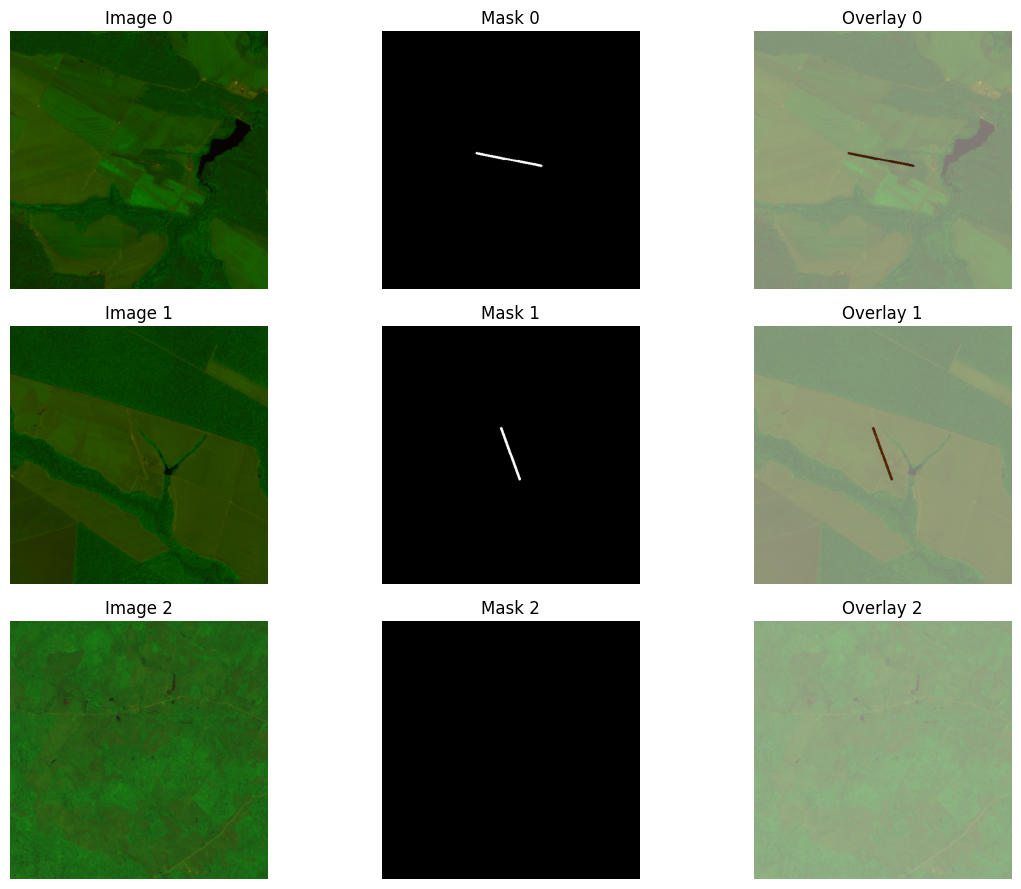

In [ ]:
# #@title 🔍 Debug Your Data Loading
# import matplotlib.pyplot as plt

# # Let's examine a few samples to see what's going wrong
# def debug_dataset(dataset, num_samples=3):
#     fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples*3))

#     for i in range(num_samples):
#         img, mask = dataset[i]

#         # Convert tensor back to numpy for visualization
#         if torch.is_tensor(img):
#             img_np = img.permute(1, 2, 0).numpy()
#         if torch.is_tensor(mask):
#             mask_np = mask.squeeze().numpy()

#         print(f"Sample {i}:")
#         print(f"  Image shape: {img.shape}, range: [{img.min():.4f}, {img.max():.4f}]")
#         print(f"  Mask shape: {mask.shape}, unique values: {torch.unique(mask)}")
#         print(f"  Positive pixels in mask: {mask.sum().item()}/{mask.numel()} ({100*mask.sum()/mask.numel():.2f}%)")

#         # Plot
#         axes[i, 0].imshow(img_np)
#         axes[i, 0].set_title(f'Image {i}')
#         axes[i, 0].axis('off')

#         axes[i, 1].imshow(mask_np, cmap='gray')
#         axes[i, 1].set_title(f'Mask {i}')
#         axes[i, 1].axis('off')

#         # Overlay
#         axes[i, 2].imshow(img_np)
#         axes[i, 2].imshow(mask_np, alpha=0.5, cmap='Reds')
#         axes[i, 2].set_title(f'Overlay {i}')
#         axes[i, 2].axis('off')

#     plt.tight_layout()
#     plt.show()

# # Debug your training dataset
# debug_dataset(train_ds, num_samples=3)

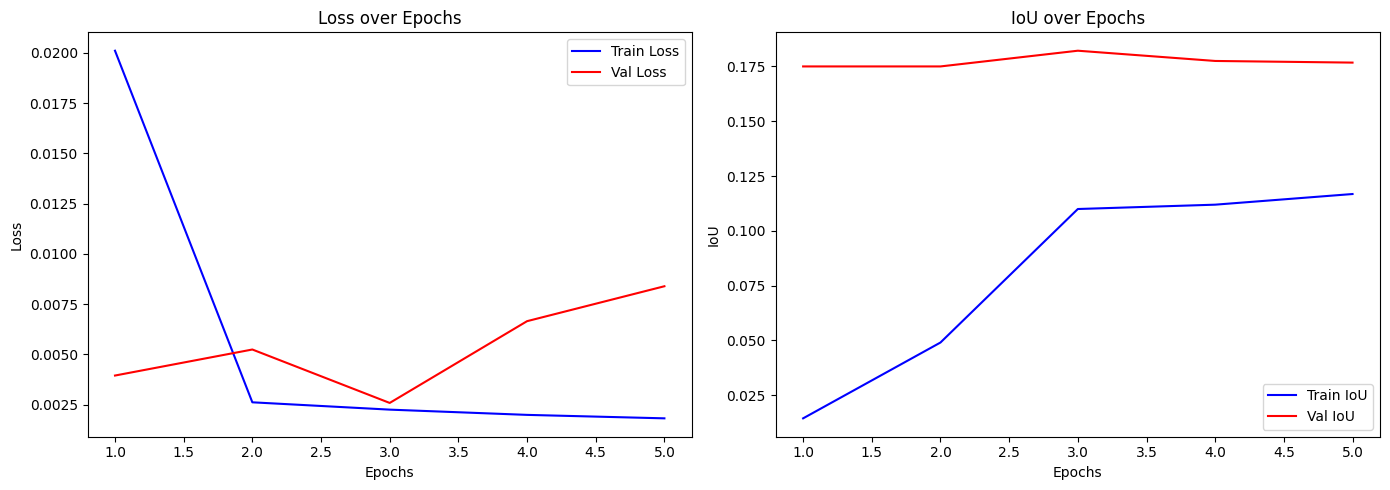

In [ ]:
# # @title 📉 Visualize Training Metrics
# import matplotlib.pyplot as plt

# def plot_metrics(train_losses, val_losses, train_ious, val_ious):
#     epochs = range(1, len(train_losses)+1)

#     plt.figure(figsize=(14,5))

#     plt.subplot(1,2,1)
#     plt.plot(epochs, train_losses, 'b', label='Train Loss')
#     plt.plot(epochs, val_losses, 'r', label='Val Loss')
#     plt.title('Loss over Epochs')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.subplot(1,2,2)
#     plt.plot(epochs, train_ious, 'b', label='Train IoU')
#     plt.plot(epochs, val_ious, 'r', label='Val IoU')
#     plt.title('IoU over Epochs')
#     plt.xlabel('Epochs')
#     plt.ylabel('IoU')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # If your training loop stores this data:
# plot_metrics(history['train_loss'], history['val_loss'], history['train_iou'], history['val_iou'])


In [ ]:
# # @title 💾 Save Model to Google Drive
# model_save_path = "/content/drive/MyDrive/My models/trained_model.pth"
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to: {model_save_path}")


Saving id_160.tif to id_160 (1).tif


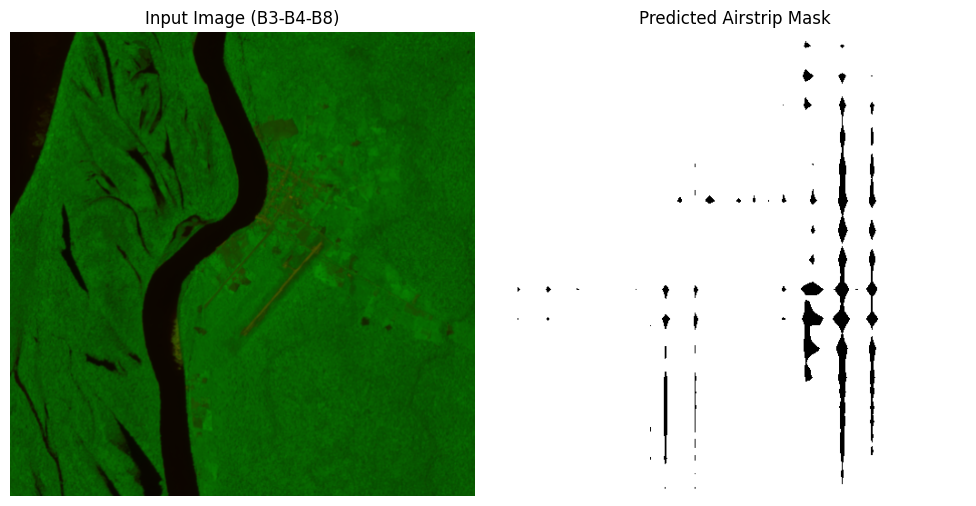

In [ ]:
# # @title 🖼️ Upload and Predict on Custom Local Image

# from google.colab import files
# import os
# import rasterio
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2

# # Step 1: Upload .tif from local machine
# uploaded = files.upload()
# custom_img_path = list(uploaded.keys())[0]

# # Step 2: Load and Resize Image
# def load_custom_image(path, selected_band_indices=[3, 4, 8]):
#     with rasterio.open(path) as src:
#         img = src.read(selected_band_indices).astype(np.float32)
#         img = np.clip(img / 10000.0, 0, 1)
#         img = np.nan_to_num(img)
#         img = np.transpose(img, (1, 2, 0))  # HWC

#     img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_LINEAR)
#     img = np.transpose(img, (2, 0, 1))  # CHW
#     return img

# # Step 3: Prepare image tensor
# custom_img = load_custom_image(custom_img_path)
# input_tensor = torch.tensor(custom_img).unsqueeze(0).float().to(device)

# # Step 4: Predict with trained model
# model.eval()
# with torch.no_grad():
#     output = model(input_tensor)
#     pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
#     pred_mask = (pred_mask > 0.5).astype('uint8')

# # Step 5: Visualize
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(custom_img[:3].transpose(1, 2, 0))  # RGB approx
# plt.title("Input Image (B3-B4-B8)")
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(pred_mask, cmap='gray')
# plt.title("Predicted Airstrip Mask")
# plt.axis('off')
# plt.tight_layout()
# plt.show()
